In [17]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax.config import config
config.update("jax_enable_x64", True)
import scienceplots

plt.style.use(['science','ieee'])


Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [18]:
signal_params = ConfigDict(KDV_params_traveling)
print(signal_params)

Advection_basis_name: constant
E: 30
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 1.0
nx: 64
tmax: 1.0
xmax: 3.141592653589793
xmin: -3.141592653589793



Next, we update the method to have 512 spatial resolution, as to mimimise spatial errors, we choose $dt = (10^{-5}) i$, for $i=1,...,1/16$. $T_{max} = 0.01$. 

In [19]:
signal_params.update(E=1,method='Dealiased_SETDRK4',dt=1e-5,tmax= 0.1,nx = 256,P=1,S=0,noise_magnitude=5)


Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [20]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

In [21]:
key1 = jax.random.PRNGKey(0)
dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
#dW = -0.1*jnp.ones_like(dW)
dW = dW
final, all = signal_model.run(initial_signal, signal_model.nmax,dW) #the final input is scan length? 
print(final.shape,all.shape)

(1, 256) (10000, 1, 256)


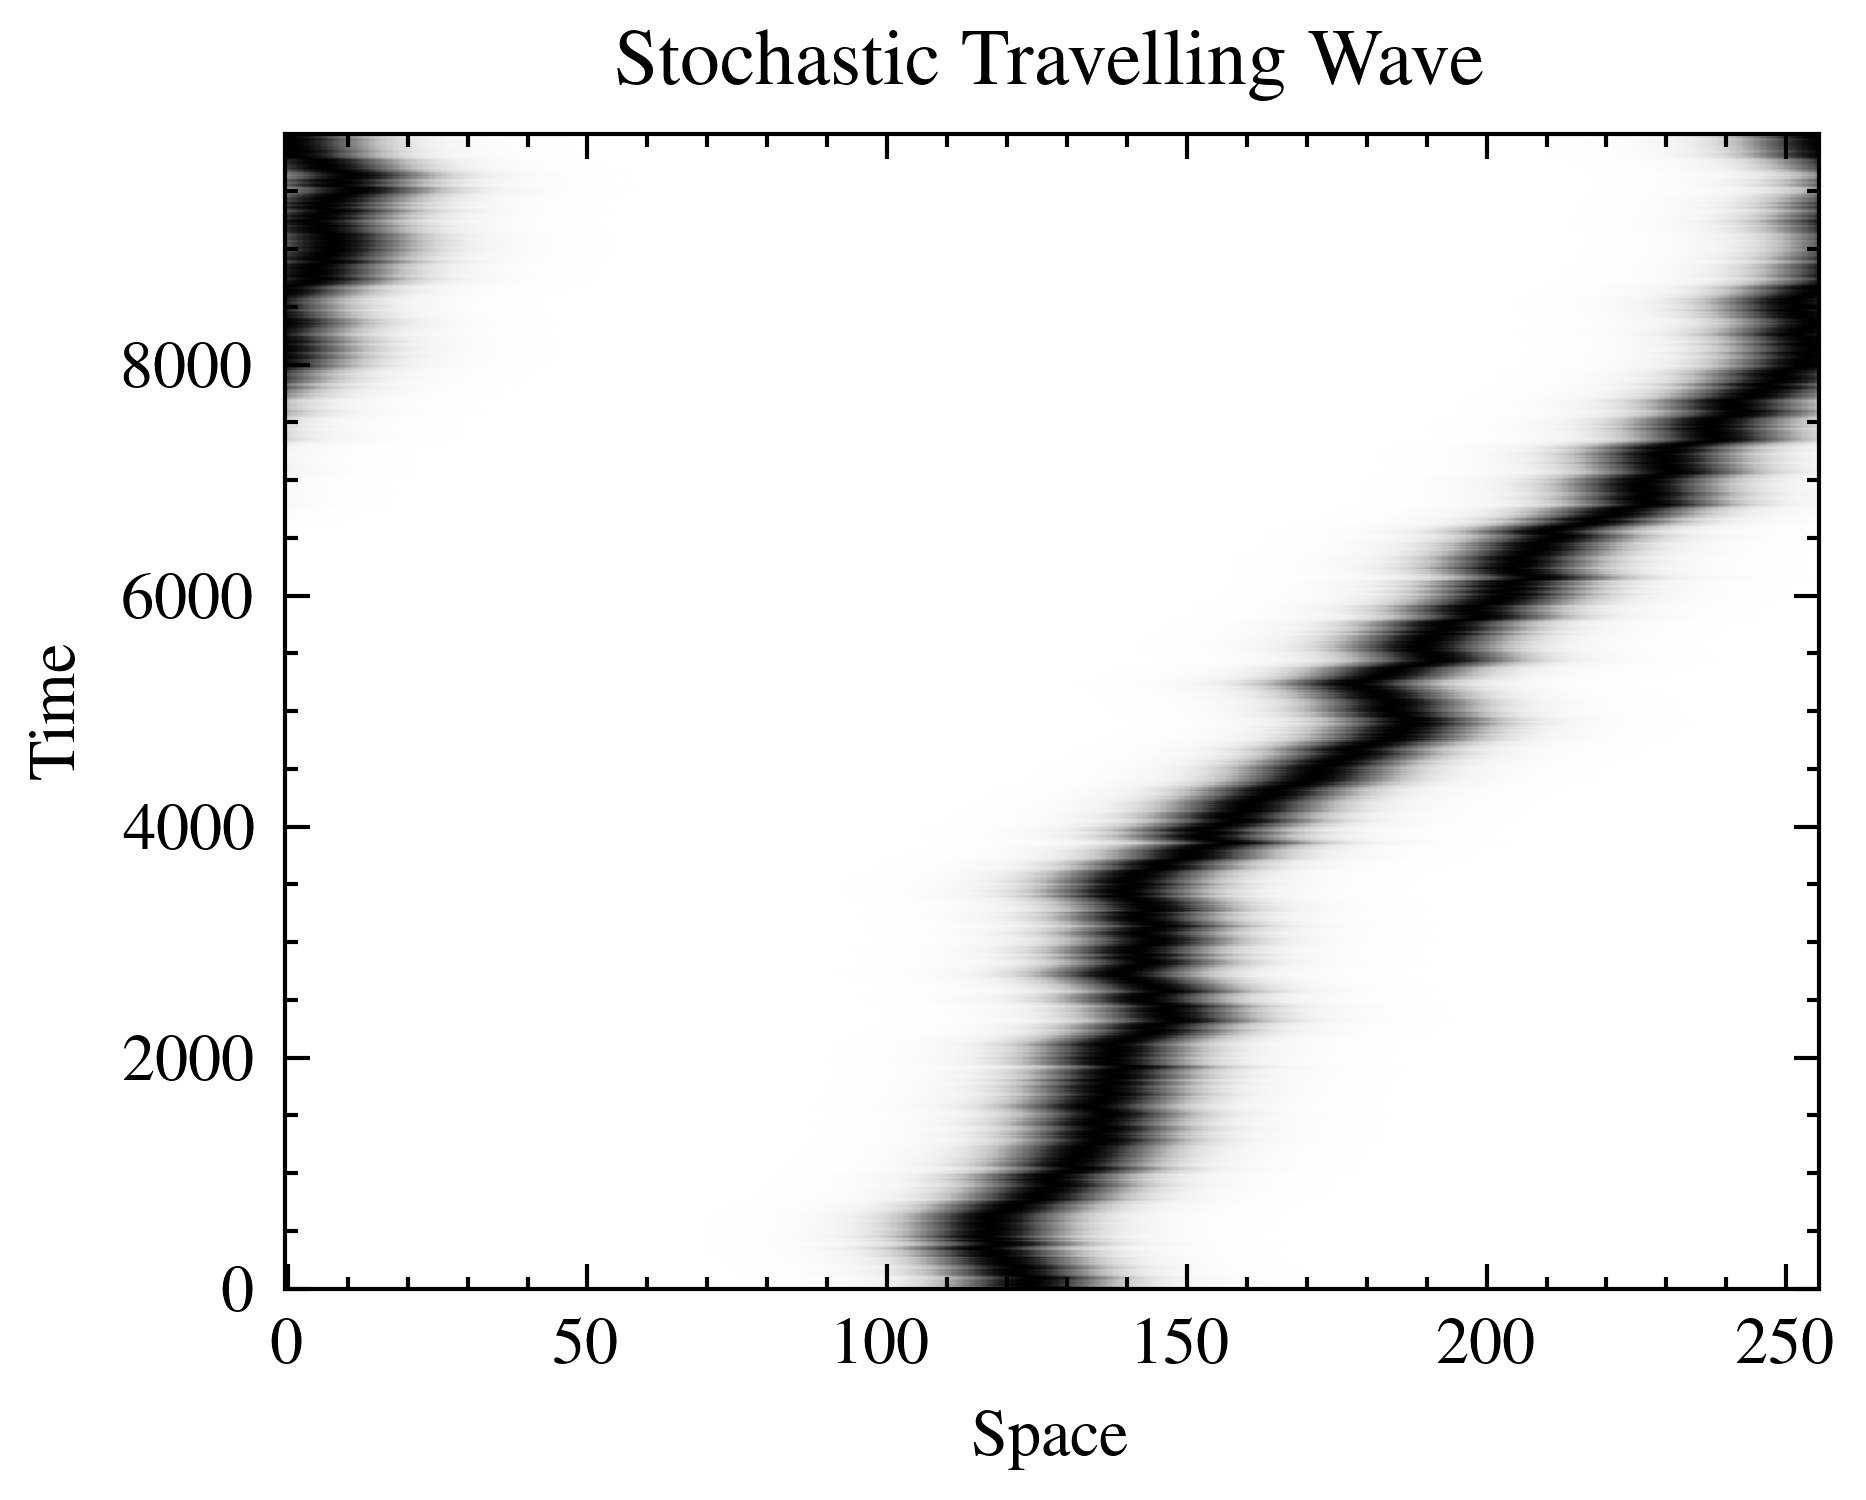

In [ ]:
plt.title('Numerical Stochastic Travelling Wave')
plt.imshow(all[:,0,:],aspect='auto',cmap='Grays',origin='lower')
plt.xlabel('Space')
plt.ylabel('Time')
plt.show()

In [23]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal
#out shape is (n_total, n_particles, n_dim)

<class 'jaxlib.xla_extension.ArrayImpl'>
10000
(1, 256)
(1, 256)


$\xi(x)  = 1$
$u_t + uu_x + u_{xxx} = 0$
let $\cosh(x-c t)$ be the travelling wave.
then 
$\cosh(x-c t - W(t))$


$1/2[\xi_p,\xi_q]J_{p,q}$ where $p\neq q$, and $J = \int \int \circ dW\circ dW$

In [24]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)
W = jnp.cumsum(dW, axis=0)
W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
print(W.shape)
W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
W_new = W_new.at[1:,:,:].set(W)

E = signal_model.params.E
nmax = signal_model.nmax
nx = signal_model.params.nx
x = signal_model.x
xmax = signal_model.params.xmax
xmin = signal_model.params.xmin
dt = signal_model.params.dt

analytic = jnp.zeros([nmax+1, E, nx])
#analytic = analytic.at[0,:,:].set(initial_signal)
beta = 3.0

#ans = initial_condition( (x - 4*beta**2 * (dt*n) - 1/2*W[n,:,0] + xmax)%(xmax*2) - xmax , E, signal_params.initial_condition)
# print(ans.shape,x.shape, E , W.shape)
initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))

for n in range(signal_model.nmax+1):
    ans = initial_condition_jitted((x - 4*beta**2 * (dt*n) - 1/2*W_new[n,:,:] + xmax)%(xmax*2) - xmax, E, signal_params.initial_condition)
    analytic = analytic.at[n,:,:].set(ans)

# takes a min at higher resolution.


(1, 256)
(10000, 1, 256)
(10001, 1, 256)
(10000, 1, 1)


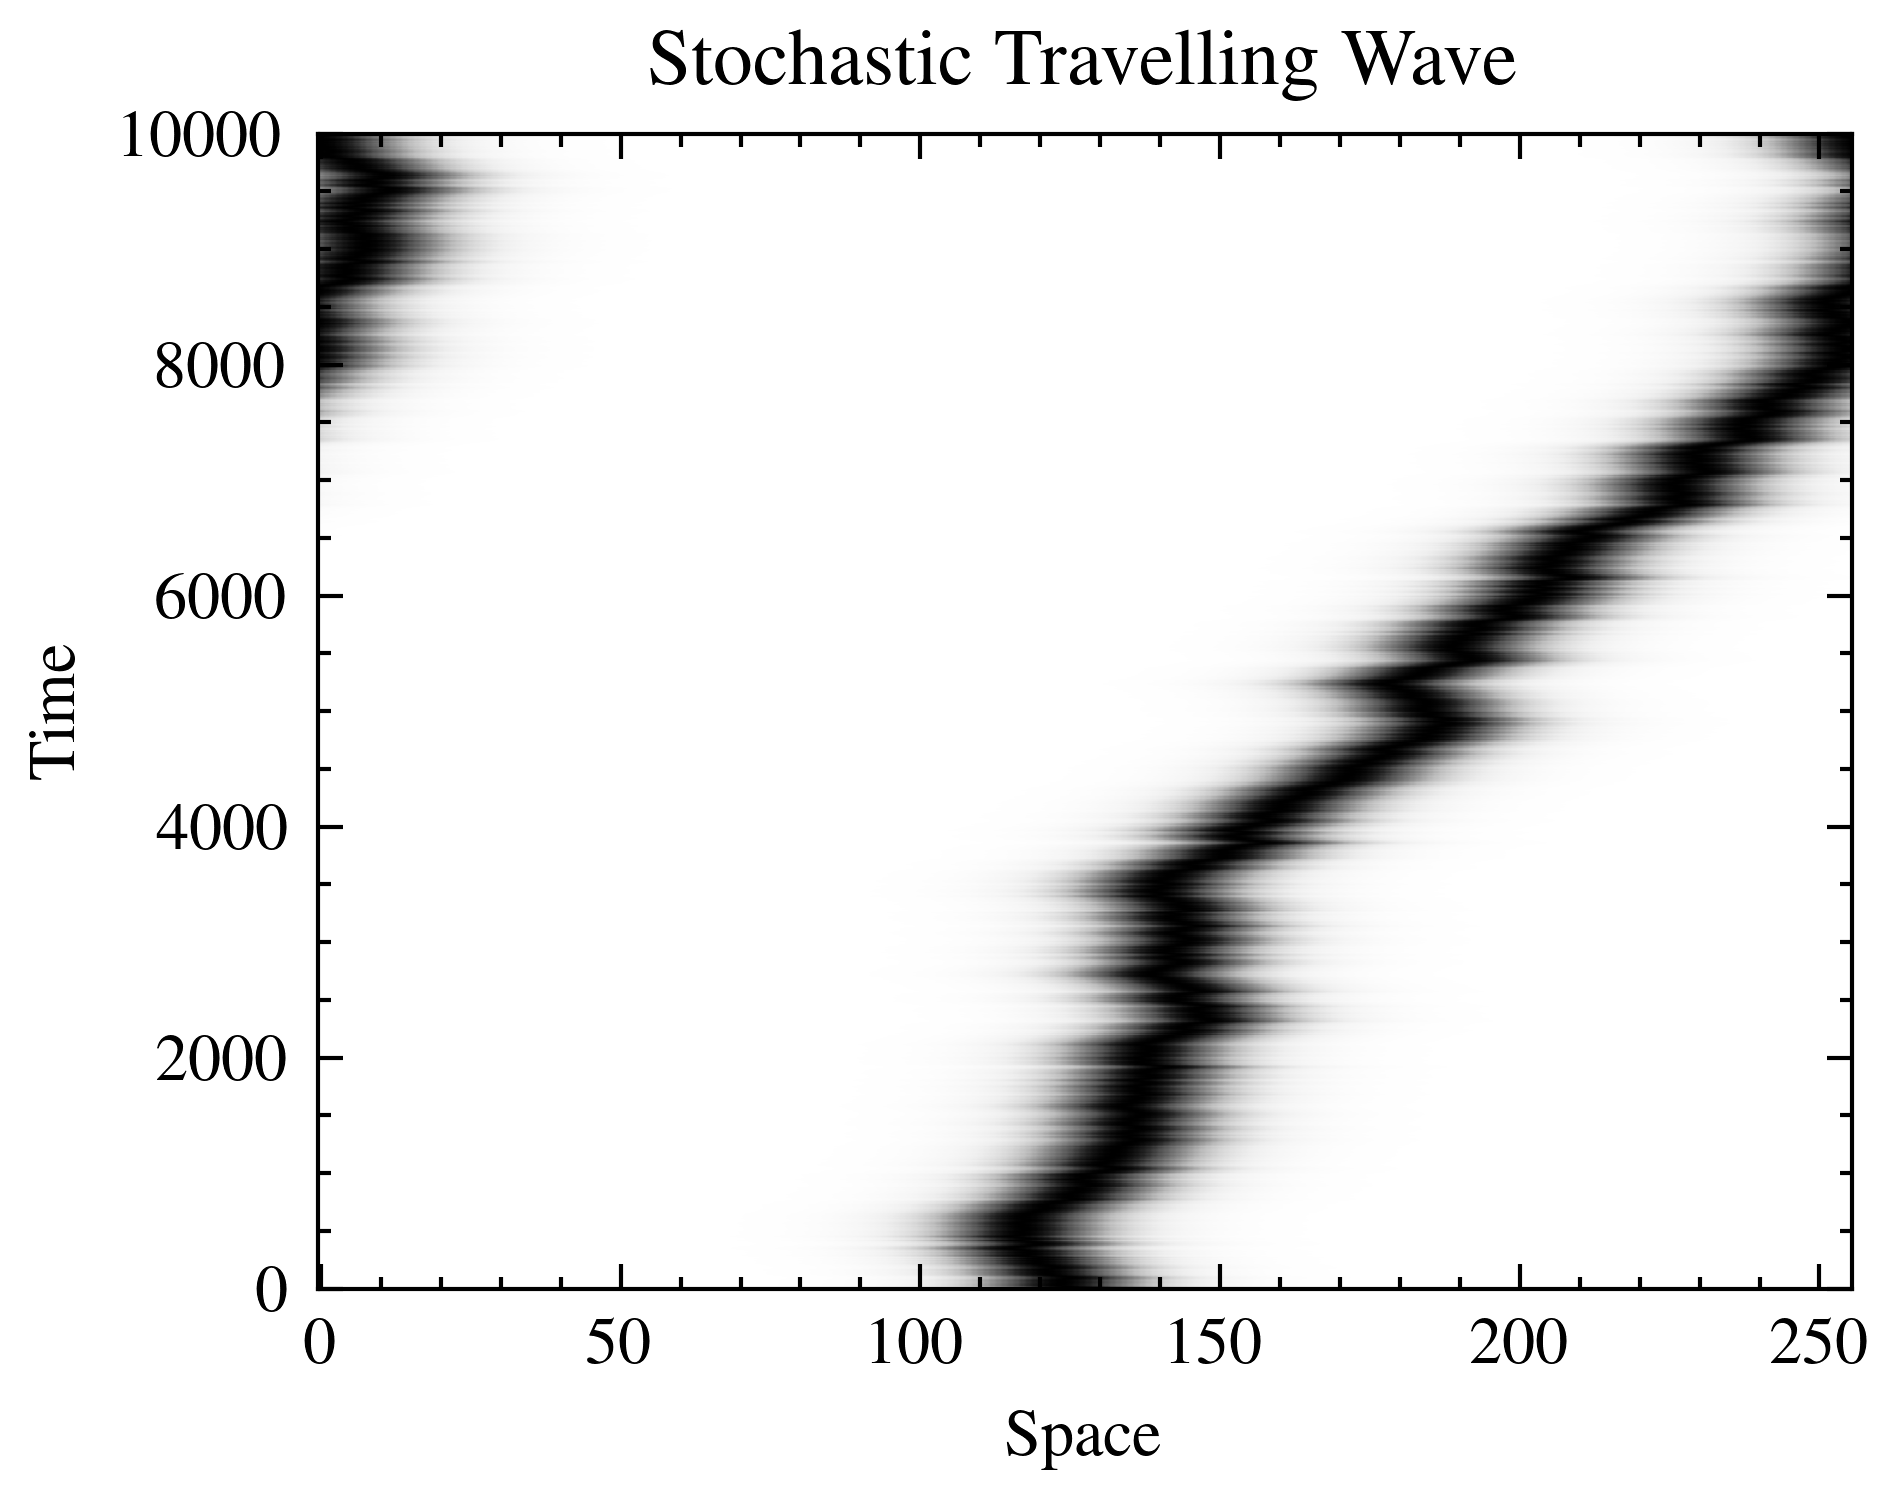

In [ ]:
plt.title('Analytic Stochastic Travelling Wave')
plt.imshow(analytic[:,0,:],aspect='auto',cmap='Grays',origin='lower')
plt.xlabel('Space')
plt.ylabel('Time')
plt.show()

In [25]:
def plot(da_step):
    plt.title(f"da_step = {da_step}")
    plt.plot(signal_model.x, signal[da_step,:,:].T, color='k',linewidth=0.2,label='signal')
    plt.plot(signal_model.x, analytic[da_step,:,:].T, color='r',linewidth=0.2,label='analytic')
    plt.legend()
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))


(10001, 1, 256) (10001, 1, 256)


interactive(children=(IntSlider(value=5000, description='da_step', max=10000), Output()), _dom_classes=('widge…

<function __main__.plot(da_step)>

In [26]:
def plot(da_step):
    plt.title('Difference between signal and analytic')
    plt.plot(signal_model.x, signal[da_step,:,:].T-analytic[da_step,:,:].T, color='k',linewidth=2)
    plt.legend(['signal'])
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))

(10001, 1, 256) (10001, 1, 256)


interactive(children=(IntSlider(value=5000, description='da_step', max=10000), Output()), _dom_classes=('widge…

<function __main__.plot(da_step)>

In [27]:
def relative_error(signal, analytic):
    return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)

print( jnp.linalg.norm(signal[1,:,:]- analytic[1,:,:]))# this should be zero
print(relative_error(signal[:,:,:], analytic[:,:,:]))#space time relative error.

4.092215895001157e-06
9.893242085607233e-06


In [28]:
a1 = 4.247967478221594e-05
a2 = 2.3604659249362884e-05
a3 = 3.42648301646057e-06
a4 = 9.158678289679418e-07
a5 = 1.9953825989929232e-07

# looks order 2 to me, as expected, but if dW = 0, check 4th. 

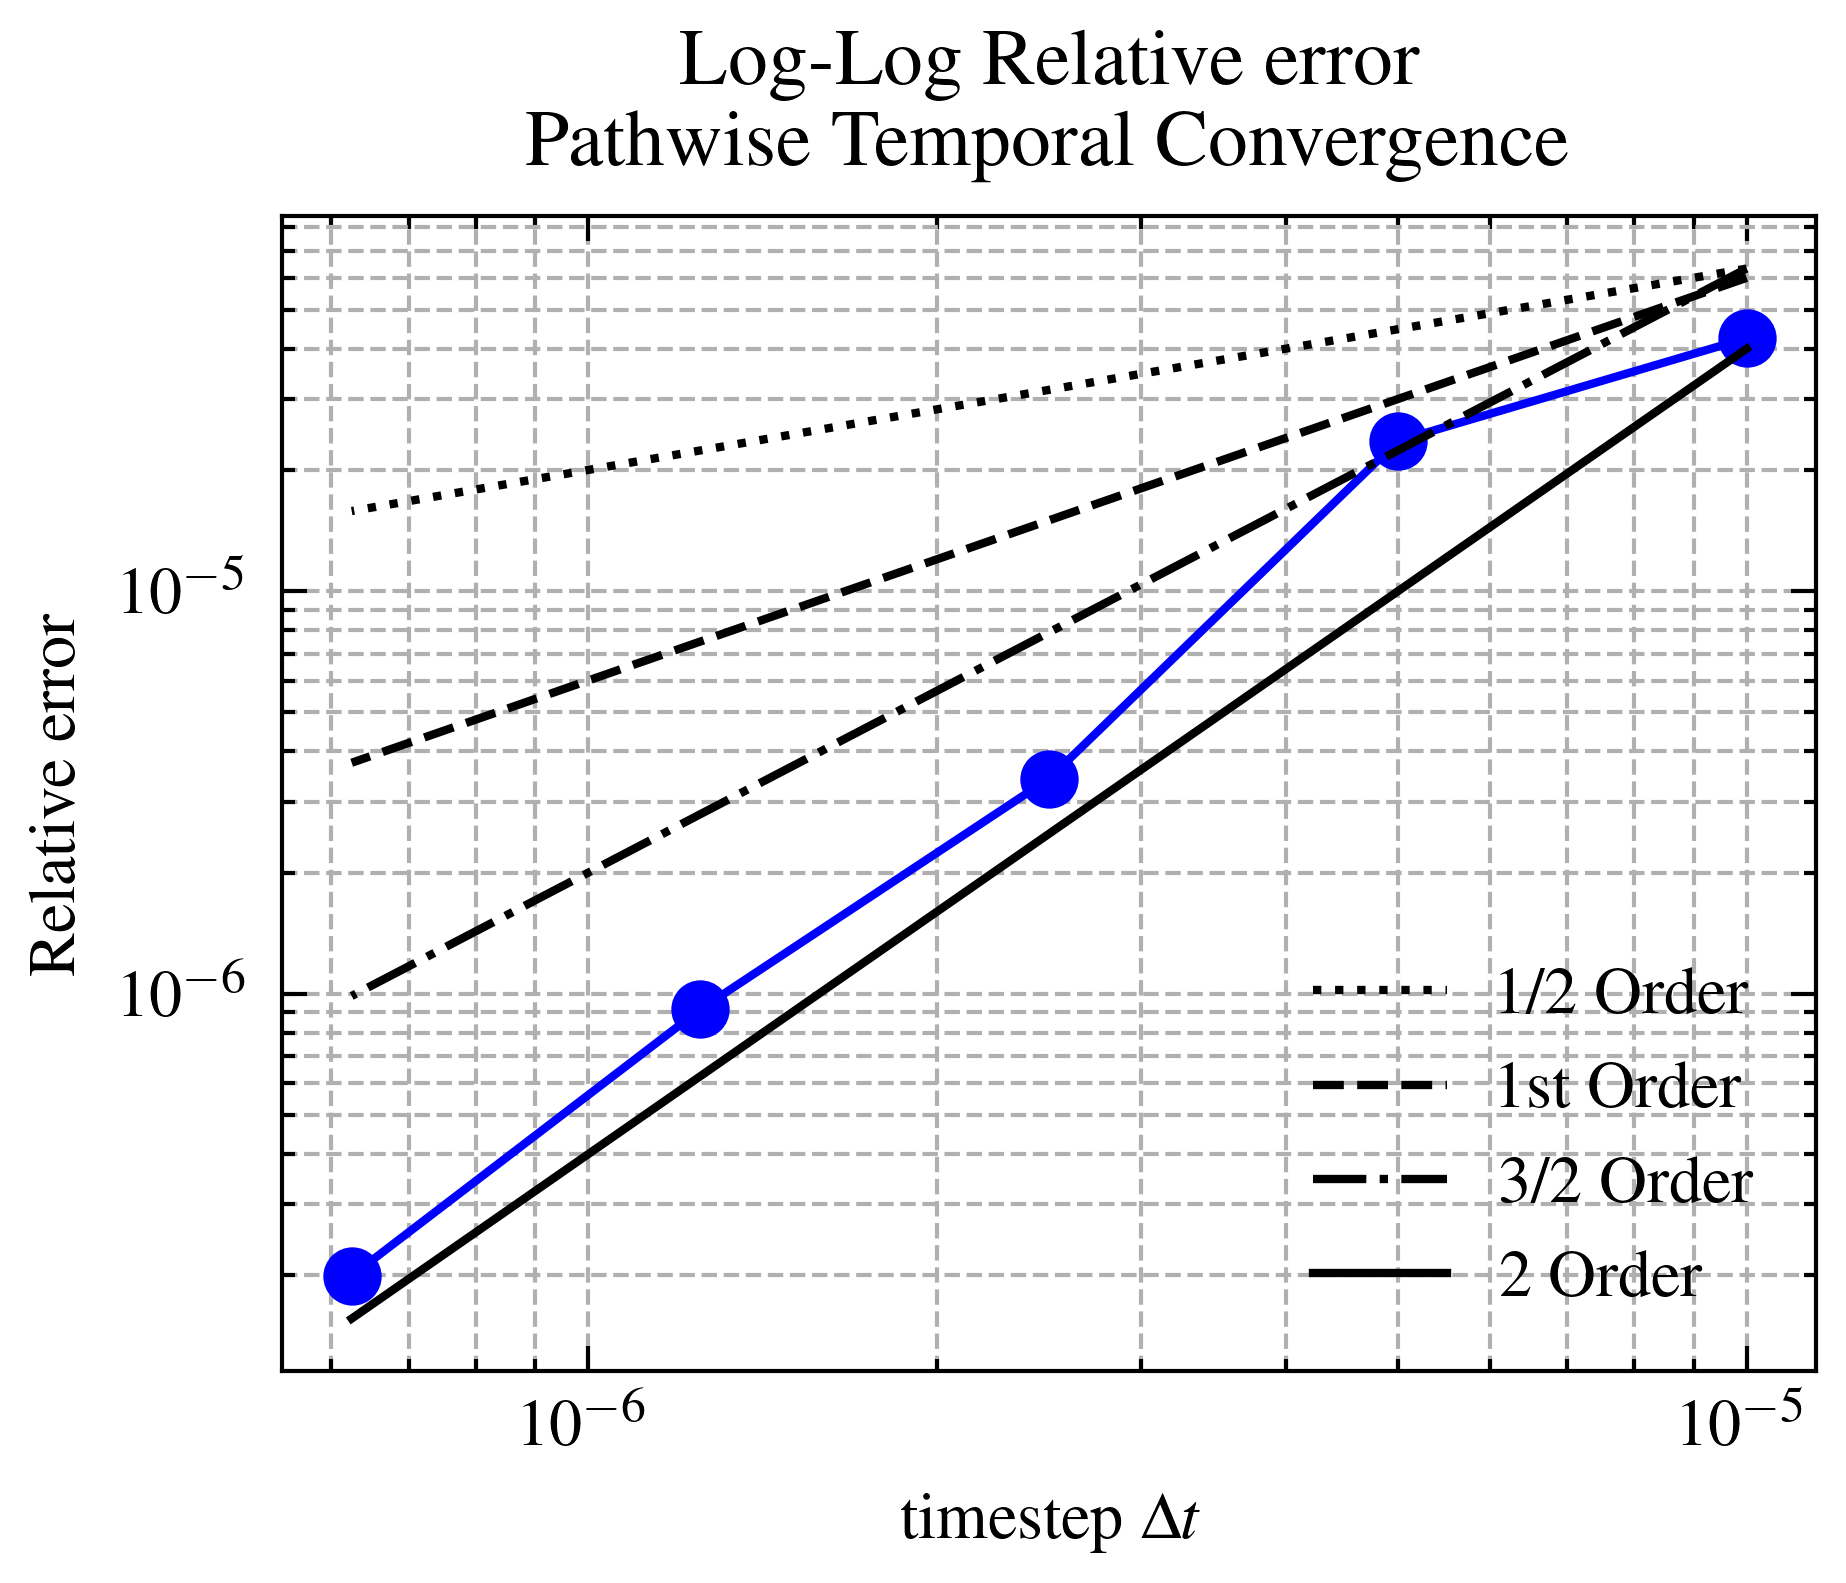

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
# Create a list of the two numbers
dt = 1e-5*np.asarray([1.,1/2,1/4,1/8,1/16])
values = np.asarray([a1, a2, a3, a4, a5])

# Create a log-log plot
plt.figure()
plt.loglog(dt, values, marker='o', linestyle='-', color='b')
plt.loglog(dt,(dt**0.5)*0.02, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt*6e0, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)*2e3, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2*4e5, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence.png',bbox_inches='tight',dpi=300)
plt.show()


Here we try and produce all the plots in one sweep, rather than rerunning seperately. 

In [ ]:
array = np.zeros(5)
for i in range(5):
    signal_params = ConfigDict(KDV_params_traveling)
    signal_params.update(E=1,method='Dealiased_SETDRK4',dt = 1e-5 * 1/2**i,tmax= 0.1,nx = 64,P=1,S=0,noise_magnitude=5)
    print(signal_params)
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    key1 = jax.random.PRNGKey(0)
    dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
    dW = dW
    final, all = signal_model.run(initial_signal, signal_model.nmax, dW) #the final input is scan length? 

    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    W = jnp.cumsum(dW, axis=0)
    W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
    W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
    W_new = W_new.at[1:,:,:].set(W)

    E = signal_model.params.E
    nmax = signal_model.nmax
    nx = signal_model.params.nx
    x = signal_model.x
    xmax = signal_model.params.xmax
    xmin = signal_model.params.xmin
    dt = signal_model.params.dt

    analytic = jnp.zeros([nmax+1, E, nx])
    beta = 3.0
    initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))
    for n in range(signal_model.nmax+1):
        ans = initial_condition_jitted((x - 4*beta**2 * (dt*n) - 1/2*W_new[n,:,:] + xmax)%(xmax*2) - xmax, E, signal_params.initial_condition)
        analytic = analytic.at[n,:,:].set(ans)

    def relative_error(signal, analytic):
        return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)
    
    array = array.at[i].set( relative_error(signal[:,:,:], analytic[:,:,:]) )

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 1.0e-05
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 5.0
nx: 256
tmax: 0.1
xmax: 3.141592653589793
xmin: -3.141592653589793

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 5.0e-06
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 5.0
nx: 256
tmax: 0.1
xmax: 3.141592653589793
xmin: -3.141592653589793

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 2.5e-06
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 5.0
nx: 256
tmax: 0.1
xmax: 3.141592653589793
xmin: -3.141592653589793

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 1.25e-06
equatio

(1, 256)


ValueError: x and y must have same first dimension, but have shapes (5,) and (1, 256)

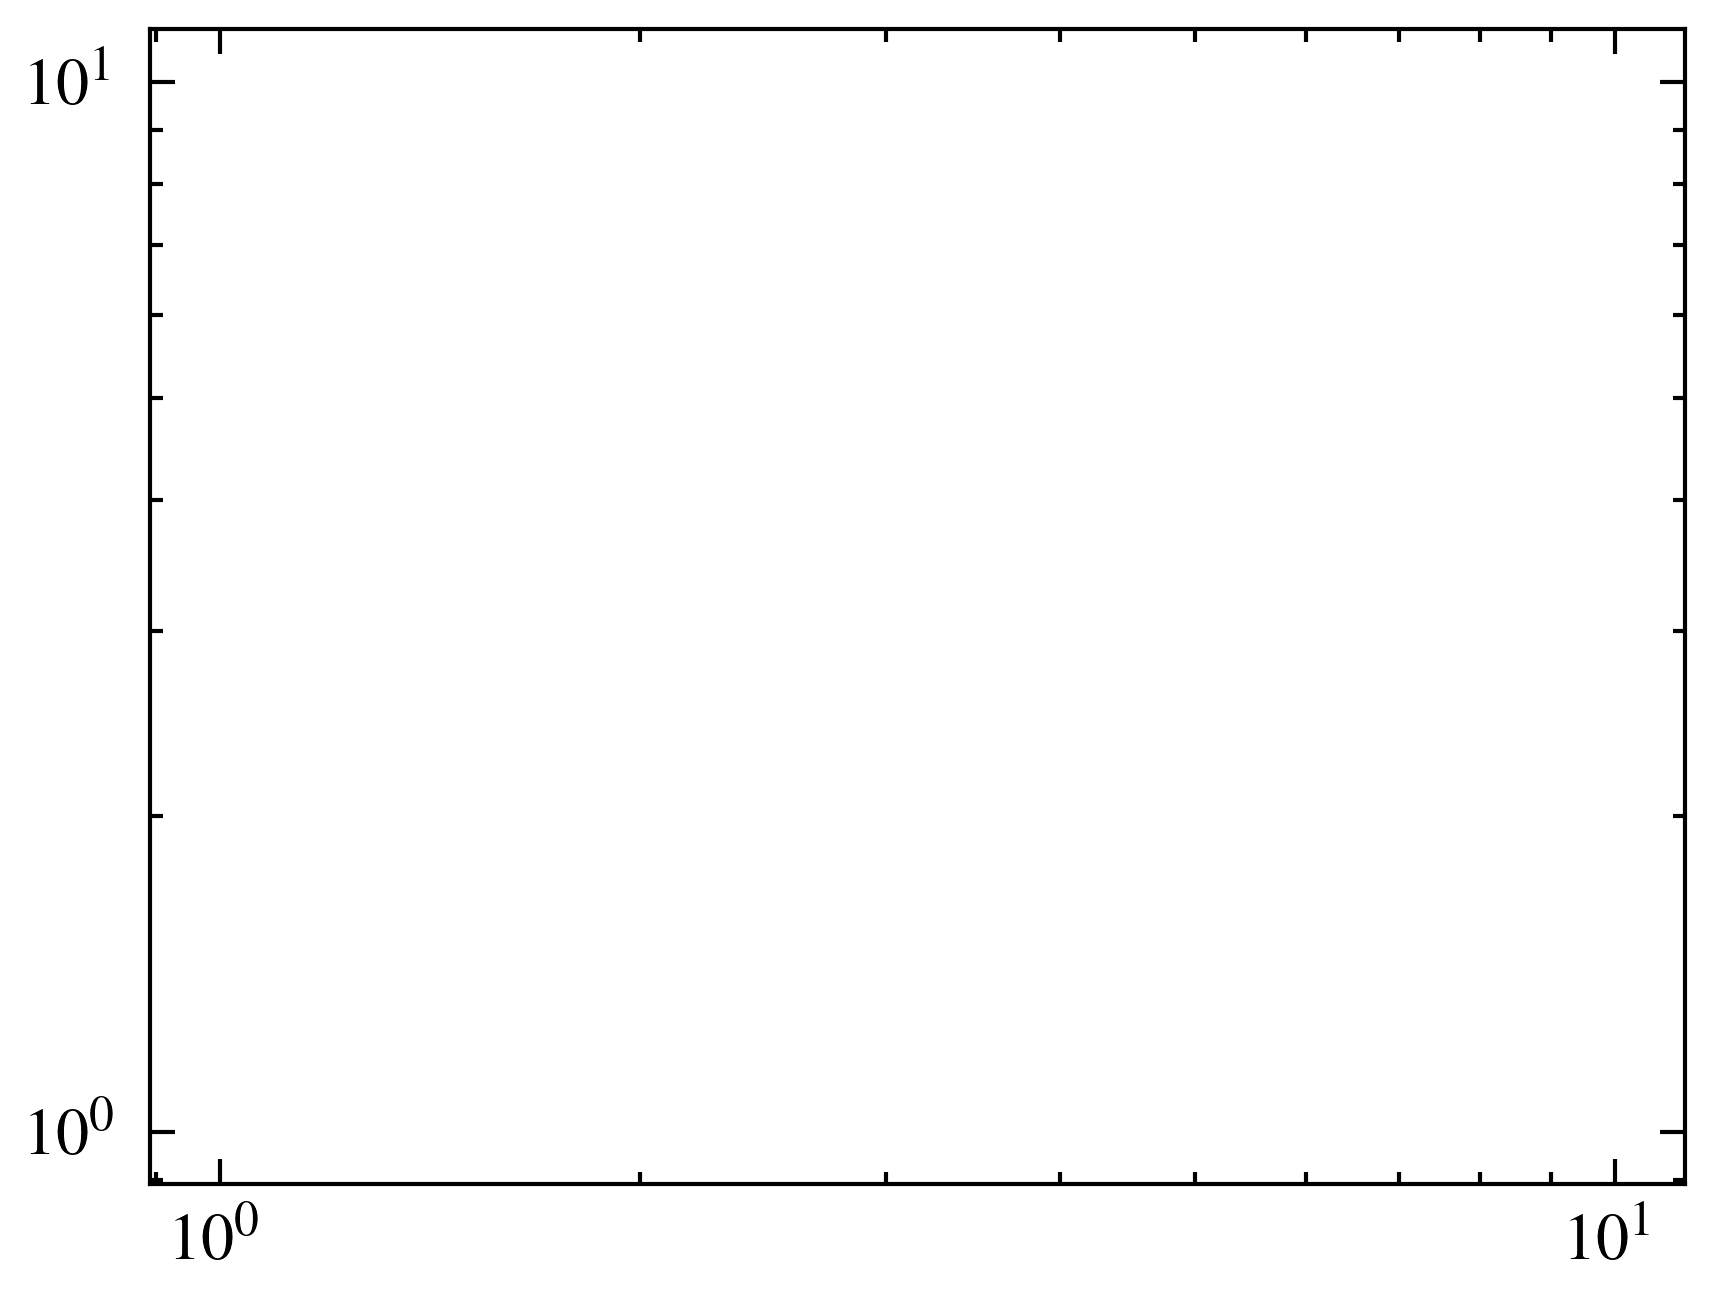

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-5*np.asarray([1.,1/2,1/4,1/8,1/16])
values = ans
print(values.shape)

plt.figure()
plt.loglog(dt, values, marker='o', linestyle='-', color='b')
plt.loglog(dt,(dt**0.5)*0.02, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt*6e0, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)*2e3, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2*4e5, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_2.png',bbox_inches='tight',dpi=300)
plt.show()